In [1]:
!pip install keras_preprocessing


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score,recall_score,f1_score



In [3]:
# Load the dataset

df = pd.read_csv("/content/Hamspam-1.csv", encoding='latin-1')
df

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or å£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...
...,...,...
5554,ham,You are a great role model. You are giving so ...
5555,ham,"Awesome, I remember the last time we got someb..."
5556,spam,"If you don't, your prize will go to another cu..."
5557,spam,"SMS. ac JSco: Energy is high, but u may not kn..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5559 non-null   object
 1   text    5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [5]:
# Check for missing values and duplicates
print(df.isnull().sum())
print(df.duplicated().sum())

type    0
text    0
dtype: int64
403


In [6]:
# Basic statistics
print(df['type'].value_counts())


type
ham     4812
spam     747
Name: count, dtype: int64


In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
# Text cleaning function
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenize
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return ' '.join(text)

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
df

,type,text,cleaned_text
0,ham,Hope you are having a good week. Just checking in,hope good week checking
1,ham,K..give back my thanks.,k give back thanks
2,ham,Am also doing in cbe only. But have to pay.,also cbe pay
3,spam,"complimentary 4 STAR Ibiza Holiday or å£10,000...",complimentary star ibiza holiday cash need urg...
4,spam,okmail: Dear Dave this is your final notice to...,okmail dear dave final notice collect tenerife...
...,...,...,...
5554,ham,You are a great role model. You are giving so ...,great role model giving much really wish day m...
5555,ham,"Awesome, I remember the last time we got someb...",awesome remember last time got somebody high f...
5556,spam,"If you don't, your prize will go to another cu...",prize go another customer c www c biz p min po...
5557,spam,"SMS. ac JSco: Energy is high, but u may not kn...",sm ac jsco energy high u may know channel day ...


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['type'], test_size=0.2, random_state=42)

# BoW
vectorizer_bow = CountVectorizer(max_features=5000)
X_train_bow = vectorizer_bow.fit_transform(X_train).toarray()
X_test_bow = vectorizer_bow.transform(X_test).toarray()


In [10]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer_tfidf.transform(X_test).toarray()


In [11]:
# Function to evaluate models
def evaluate_model(y_test, y_pred):
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred, average="weighted"):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred, average="weighted"):.4f}')
    print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted"):.4f}')


In [12]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_bow, y_train)
y_pred_lr = lr.predict(X_test_bow)
print('Logistic Regression (BoW)')
evaluate_model(y_test, y_pred_lr)

Logistic Regression (BoW)
Accuracy: 0.9775
Precision: 0.9774
Recall: 0.9775
F1-Score: 0.9769


In [13]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
print('Naive Bayes (TF-IDF)')
evaluate_model(y_test, y_pred_nb)

Naive Bayes (TF-IDF)
Accuracy: 0.9685
Precision: 0.9696
Recall: 0.9685
F1-Score: 0.9667


In [14]:
# Support Vector Machine
svc = SVC()
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)
print('SVM (TF-IDF)')
evaluate_model(y_test, y_pred_svc)

SVM (TF-IDF)
Accuracy: 0.9757
Precision: 0.9757
Recall: 0.9757
F1-Score: 0.9749


In [15]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
print('Random Forest (TF-IDF)')
evaluate_model(y_test, y_pred_rf)

Random Forest (TF-IDF)
Accuracy: 0.9730
Precision: 0.9733
Recall: 0.9730
F1-Score: 0.9719


In [16]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)



In [17]:
# LSTM Model
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to numerical values
y_train_numeric = (y_train == 'spam').astype(int)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
model.fit(X_train_pad, y_train_numeric, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping]) # Use y_train_numeric

# Convert y_test to numerical values
y_test_numeric = (y_test == 'spam').astype(int)

# Evaluate the model
y_pred_dl = model.predict(X_test_pad)
y_pred_dl = (y_pred_dl > 0.5).astype(int)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.8591 - loss: 0.3858 - val_accuracy: 0.9910 - val_loss: 0.0831
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 360ms/step - accuracy: 0.9795 - loss: 0.0793 - val_accuracy: 0.9910 - val_loss: 0.0306
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.9881 - loss: 0.0363 - val_accuracy: 0.9888 - val_loss: 0.0309
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - accuracy: 0.9924 - loss: 0.0271 - val_accuracy: 0.9865 - val_loss: 0.0354
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - accuracy: 0.9937 - loss: 0.0184 - val_accuracy: 0.9888 - val_loss: 0.0368
Epoch 5: early stopping
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [18]:
# Print evaluation metrics
print('LSTM Model')
evaluate_model(y_test_numeric, y_pred_dl)


LSTM Model
Accuracy: 0.9838
Precision: 0.9837
Recall: 0.9838
F1-Score: 0.9836


In [19]:
# Accuracy
accuracy = accuracy_score(y_test_numeric, y_pred_dl)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
class_report = classification_report(y_test_numeric, y_pred_dl)
print('Classification Report')
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_numeric, y_pred_dl)
print('Confusion Matrix')
print(conf_matrix)


Accuracy: 0.98
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       963
           1       0.96      0.91      0.94       149

    accuracy                           0.98      1112
   macro avg       0.98      0.95      0.96      1112
weighted avg       0.98      0.98      0.98      1112

Confusion Matrix
[[958   5]
 [ 13 136]]


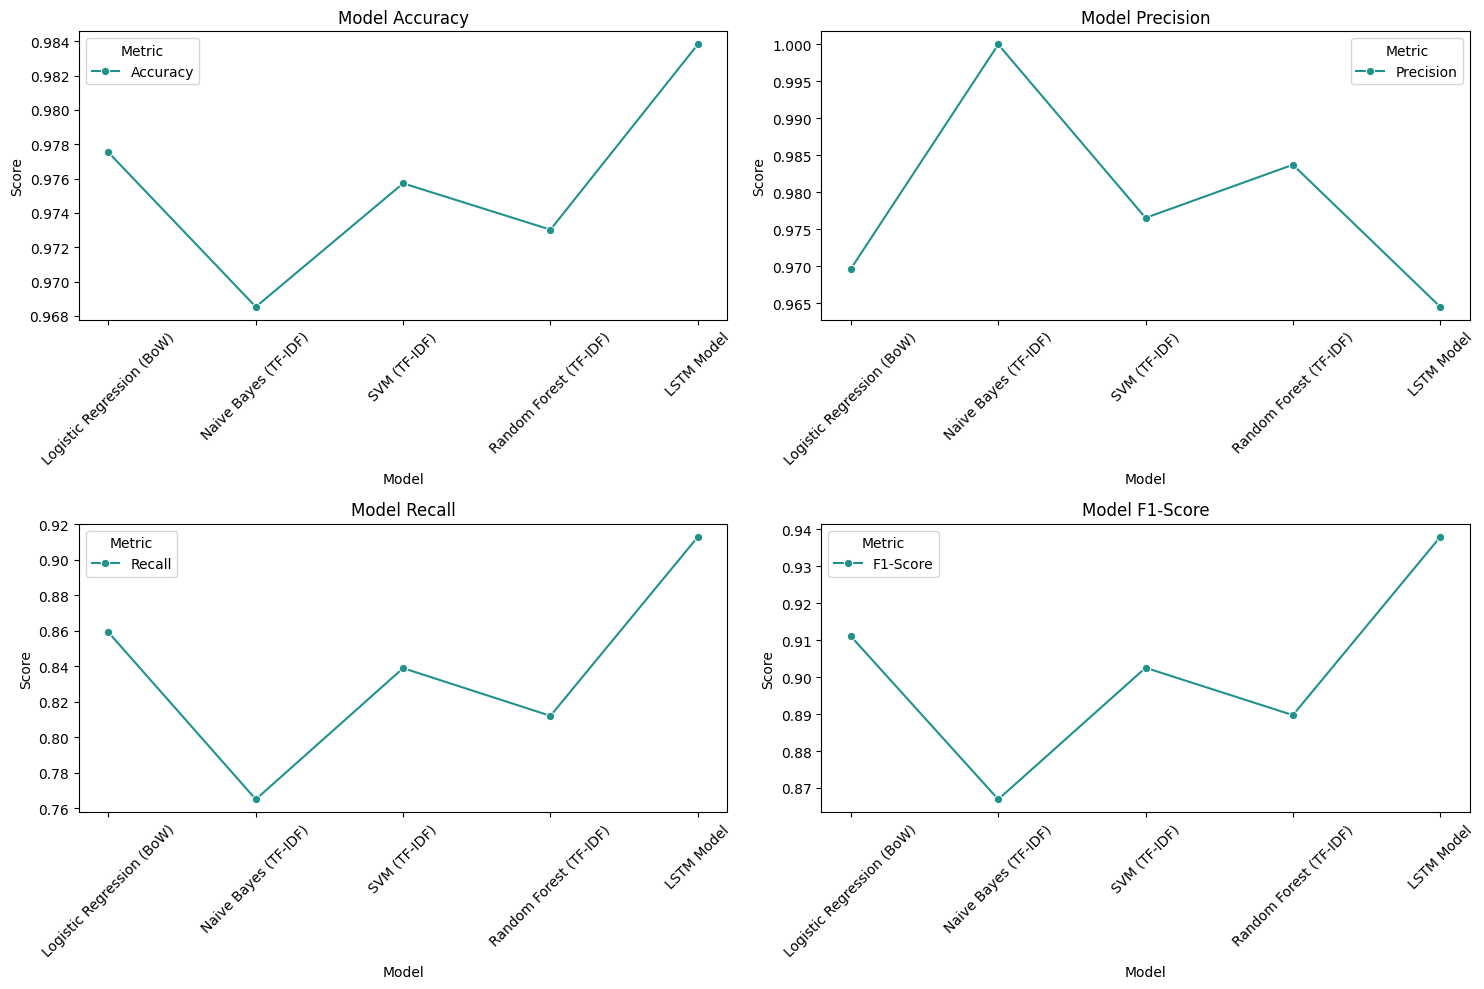

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Collecting the results from ML models
ml_results = {
    'Logistic Regression (BoW)': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr, pos_label='spam'),
        'Recall': recall_score(y_test, y_pred_lr, pos_label='spam'),
        'F1-Score': f1_score(y_test, y_pred_lr, pos_label='spam')
    },
    'Naive Bayes (TF-IDF)': {
        'Accuracy': accuracy_score(y_test, y_pred_nb),
        'Precision': precision_score(y_test, y_pred_nb, pos_label='spam'),
        'Recall': recall_score(y_test, y_pred_nb, pos_label='spam'),
        'F1-Score': f1_score(y_test, y_pred_nb, pos_label='spam')
    },
    'SVM (TF-IDF)': {
        'Accuracy': accuracy_score(y_test, y_pred_svc),
        'Precision': precision_score(y_test, y_pred_svc, pos_label='spam'),
        'Recall': recall_score(y_test, y_pred_svc, pos_label='spam'),
        'F1-Score': f1_score(y_test, y_pred_svc, pos_label='spam')
    },
    'Random Forest (TF-IDF)': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf, pos_label='spam'),
        'Recall': recall_score(y_test, y_pred_rf, pos_label='spam'),
        'F1-Score': f1_score(y_test, y_pred_rf, pos_label='spam')
    }
}

# Collecting the results from DL model
dl_results = {
    'LSTM Model': {
        'Accuracy': accuracy_score(y_test_numeric, y_pred_dl),
        'Precision': precision_score(y_test_numeric, y_pred_dl),
        'Recall': recall_score(y_test_numeric, y_pred_dl),
        'F1-Score': f1_score(y_test_numeric, y_pred_dl)
    }
}

# Combine results into a DataFrame
ml_results_df = pd.DataFrame(ml_results).T
dl_results_df = pd.DataFrame(dl_results).T
results_df = pd.concat([ml_results_df, dl_results_df], axis=0)

results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

# Melt DataFrame for easier plotting with seaborn
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plotting the comparison with line plots
plt.figure(figsize=(15, 10))

# Line plot for Accuracy
plt.subplot(2, 2, 1)
sns.lineplot(x='Model', y='Score', hue='Metric', data=results_melted[results_melted['Metric'] == 'Accuracy'], marker='o', palette='viridis')
plt.title('Model Accuracy')
plt.xticks(rotation=45)

# Line plot for Precision
plt.subplot(2, 2, 2)
sns.lineplot(x='Model', y='Score', hue='Metric', data=results_melted[results_melted['Metric'] == 'Precision'], marker='o', palette='viridis')
plt.title('Model Precision')
plt.xticks(rotation=45)

# Line plot for Recall
plt.subplot(2, 2, 3)
sns.lineplot(x='Model', y='Score', hue='Metric', data=results_melted[results_melted['Metric'] == 'Recall'], marker='o', palette='viridis')
plt.title('Model Recall')
plt.xticks(rotation=45)

# Line plot for F1-Score
plt.subplot(2, 2, 4)
sns.lineplot(x='Model', y='Score', hue='Metric', data=results_melted[results_melted['Metric'] == 'F1-Score'], marker='o', palette='viridis')
plt.title('Model F1-Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
